In [3]:
import sys
import os

repo_root = os.path.abspath(os.path.join(os.path.dirname(os.getcwd())))
sys.path.append(repo_root)

print(repo_root)

/home/jayeun/core_classes/proj_energy_volatility


In [4]:
import openmeteo_requests
import requests_cache
from retry_requests import retry

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import acf, adfuller, coint
from src.models.ARIMA import ARIMA_model
from sklearn.model_selection import TimeSeriesSplit

In [5]:
plt.style.use("styler.mplstyle") 

### Pre-Processing

In [6]:
def get_daily_weather(lats, longs, start, end, variables) -> pd.DataFrame:
    cache_session = requests_cache.CachedSession(".cache", expire_after=3600)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    openmeteo = openmeteo_requests.Client(session=retry_session)

    url = "https://archive-api.open-meteo.com/v1/archive"

    if not isinstance(lats, (list, tuple)):  lats = [lats]
    if not isinstance(longs, (list, tuple)): longs = [longs]
    if isinstance(variables, (list, tuple)):  # <-- key change
        daily_param = ",".join(variables)
    else:
        daily_param = variables  # already a CSV string

    params = {
        "latitude": ",".join(map(str, lats)),
        "longitude": ",".join(map(str, longs)),
        "daily": daily_param,                     # <-- pass CSV
        "start_date": start,
        "end_date": end,
        "timezone": "UTC",
        # optionally: "models": "era5_land"  # good for precip/temps
    }

    responses = openmeteo.weather_api(url, params=params)

    frames = []
    for idx, resp in enumerate(responses):
        daily = resp.Daily()
        data = {
            "date": pd.date_range(
                start=pd.to_datetime(daily.Time(), unit="s", utc=True),
                end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
                freq=pd.Timedelta(seconds=daily.Interval()),
                inclusive="left",
            ),
            "lat": lats[idx],
            "lon": longs[idx],
        }
        # Map returned arrays in the same order you sent in `variables`
        vars_list = daily_param.split(",")
        for i in range(daily.VariablesLength()):
            name = vars_list[i] if i < len(vars_list) else f"var_{i}"
            data[name] = daily.Variables(i).ValuesAsNumpy()

        frames.append(pd.DataFrame(data))

    return pd.concat(frames, ignore_index=True)

def get_hourly_weather(
    lats, longs, start, end, variables
) -> pd.DataFrame:
    cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    openmeteo = openmeteo_requests.Client(session=retry_session)

    url = "https://archive-api.open-meteo.com/v1/archive"

    # Accept lists of coords for regional pulls (single values also ok)
    if not isinstance(lats, (list, tuple)): lats = [lats]
    if not isinstance(longs, (list, tuple)): longs = [longs]

    params = {
        "latitude": ",".join(map(str, lats)),
        "longitude": ",".join(map(str, longs)),
        "hourly": variables,
        "start_date": start,  # 'YYYY-MM-DD'
        "end_date": end,      # 'YYYY-MM-DD'
        "timezone": "UTC"
    }

    responses = openmeteo.weather_api(url, params=params)

    # When multiple locations are requested, the API returns an array of responses
    # in the same order as the coordinate pairs.
    frames = []
    for idx, resp in enumerate(responses):
        hourly = resp.Hourly()
        data = {
            "date": pd.date_range(
                start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
                end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
                freq=pd.Timedelta(seconds=hourly.Interval()),
                inclusive="left",
            ),
            "lat": lats[idx],
            "lon": longs[idx],
        }
        for i in range(hourly.VariablesLength()):
            name = variables[i] or f"var_{i}"
            data[name] = hourly.Variables(i).ValuesAsNumpy()
        frames.append(pd.DataFrame(data))
    return pd.concat(frames, ignore_index=True)


In [7]:
def test_differencing(time_series, max_differencing  = 5, threshold = .05):

    for i in range(max_differencing+1):
        adf, p_val, _, _, _, _  = adfuller(time_series, regression='ct')
        if p_val <= threshold:
            return i 

        time_series = time_series.diff(1).dropna()
        

    return -1 



In [8]:
HOURLY_VAR = ["temperature_2m", "relative_humidity_2m", "dew_point_2m", "apparent_temperature", "precipitation", "wind_speed_10m", "cloud_cover"]
DAILY_VAR = ["temperature_2m_max", "temperature_2m_min", "sunshine_duration", "precipitation_sum", "wind_speed_10m_max"]
START = '2020-10-27'
END = '2025-10-27'
LAT = 61.590000
LONG = -149.790000

In [9]:

# df = get_hourly_weather(LAT,LONG, START, END, HOURLY_VAR)
df = get_daily_weather(LAT, LONG, START, END, DAILY_VAR)
df['date'] = pd.to_datetime(df['date'])
# df = df.set_index('date')


In [10]:
df

,date,lat,lon,temperature_2m_max,temperature_2m_min,sunshine_duration,precipitation_sum,wind_speed_10m_max
0,2020-10-27 00:00:00+00:00,61.59,-149.79,3.365,-3.385000,17574.238281,0.0,12.768586
1,2020-10-28 00:00:00+00:00,61.59,-149.79,1.165,-3.685000,25378.222656,0.0,6.763786
2,2020-10-29 00:00:00+00:00,61.59,-149.79,-0.235,-6.285000,24979.296875,0.0,6.287130
3,2020-10-30 00:00:00+00:00,61.59,-149.79,-1.835,-8.885000,24599.201172,0.0,10.691453
4,2020-10-31 00:00:00+00:00,61.59,-149.79,-2.585,-10.735001,24386.042969,0.0,14.168641
...,...,...,...,...,...,...,...,...
1822,2025-10-23 00:00:00+00:00,61.59,-149.79,5.715,0.165000,2178.496338,1.2,11.432480
1823,2025-10-24 00:00:00+00:00,61.59,-149.79,5.115,0.615000,19896.742188,1.7,11.203464
1824,2025-10-25 00:00:00+00:00,61.59,-149.79,5.215,-0.735000,11198.342773,1.2,11.870451
1825,2025-10-26 00:00:00+00:00,61.59,-149.79,2.065,-1.135000,11101.562500,0.0,8.149847


In [11]:
def plot_time_series(lat: float, lon: float, df: pd.DataFrame, variable: str):

    fig, ax = plt.subplots(figsize=(10, 6))
    fig.patch.set_facecolor("white")
    print(variable)
    # Plot the selected variable

    x = df['date'] 
    y = df[variable]

    ax.plot(
        x, 
        y, 
        color="tab:blue", 
        linewidth=1.8, 
        label=str(variable).replace("_", " ").title()
    )

    ax.set_title(
        f"Hourly {variable.replace('_', ' ')} at ({lat:.2f}, {lon:.2f})",
        fontsize=14,
        fontweight="bold",
        pad=12
    )
    ax.set_xlabel("Time (UTC)", fontsize=12)
    ax.set_facecolor("lightgrey")
    ax.set_ylabel(variable.replace("_", " ").title(), fontsize=12)
    ax.legend(frameon=True)
    plt.tight_layout()
    plt.show()

### Temperature 

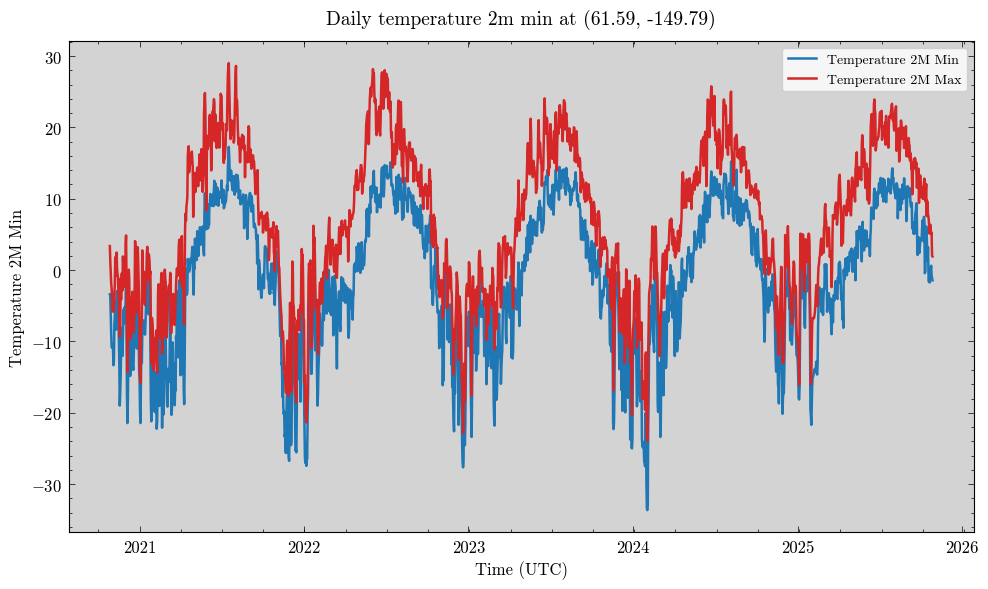

In [12]:


fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor("white")

x = df['date'] 
y = df['temperature_2m_min']
y_2 = df['temperature_2m_max']

ax.plot(
    x, 
    y, 
    color="tab:blue", 
    linewidth=1.8, 
    label=str('temperature_2m_min').replace("_", " ").title()
)

ax.plot(
    x, 
    y_2, 
    color="tab:red", 
    linewidth=1.8, 
    label=str('temperature_2m_max').replace("_", " ").title(),
   
)

ax.set_title(
    f"Daily {'temperature_2m_min'.replace('_', ' ')} at ({LAT:.2f}, {LONG:.2f})",
    fontsize=14,
    fontweight="bold",
    pad=12
)
ax.set_xlabel("Time (UTC)", fontsize=12)
ax.set_facecolor("lightgrey")
ax.set_ylabel('temperature_2m_min'.replace("_", " ").title(), fontsize=12)
ax.legend(frameon=True)
plt.tight_layout()
plt.show()

In [13]:
adf, p_val, _, _, _, _  = adfuller(df['temperature_2m_max'], regression='c')
adf

np.float64(-2.3009843374538943)

### Cloud Cover

sunshine_duration


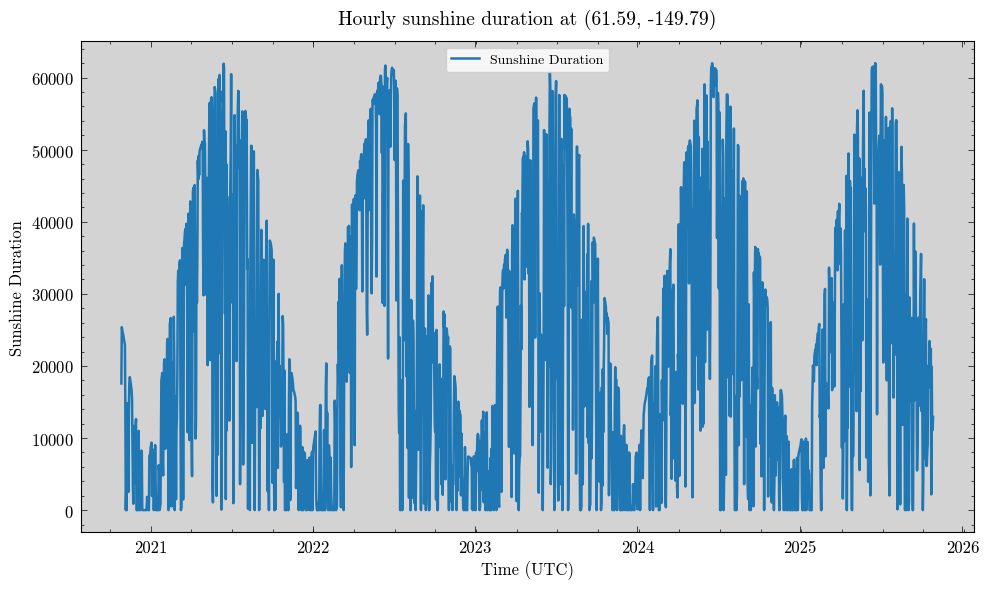

In [14]:
plot_time_series(LAT, LONG, df, 'sunshine_duration')

### Wind Speed

wind_speed_10m_max


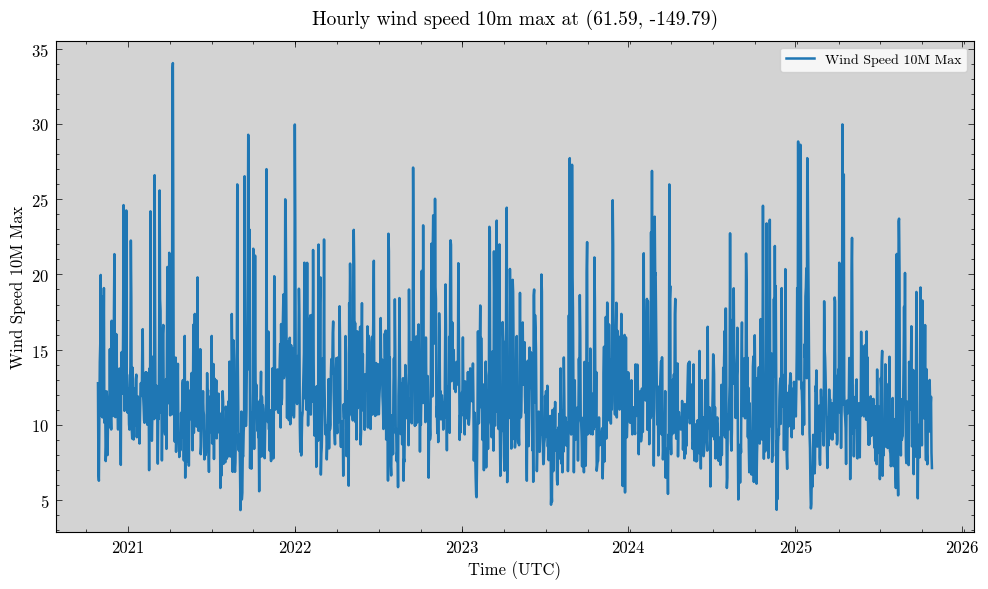

In [15]:
plot_time_series(LAT, LONG, df, 'wind_speed_10m_max')

### ARIMA Modeling

In [16]:
tscv = TimeSeriesSplit(n_splits=5)

In [17]:
model = ARIMA_model(df['temperature_2m_max'], (1,1,3))
model.fit()
h = 15
forecast, low, high = model.forecast(steps=h)

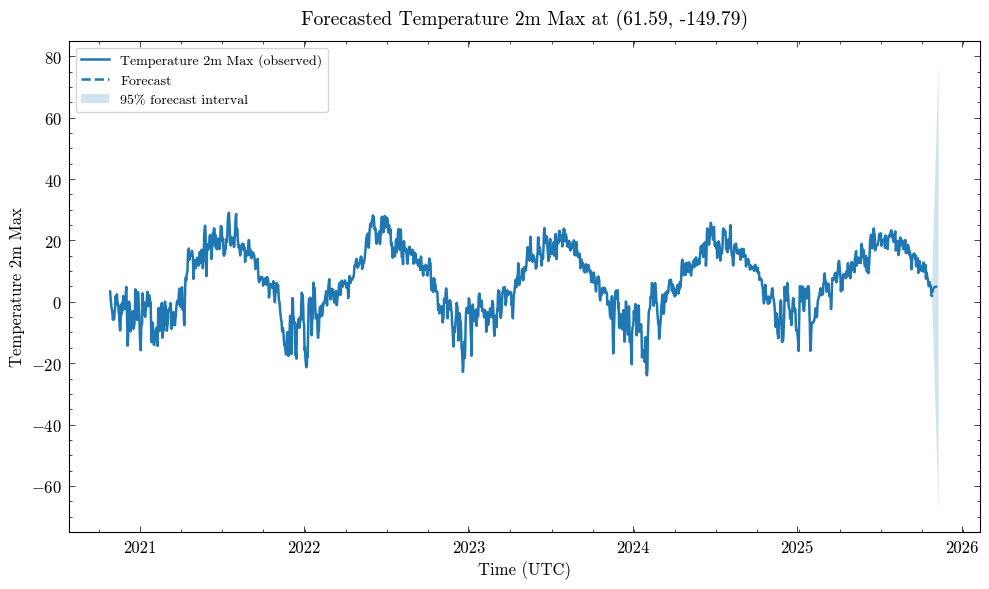

In [18]:
last_date = pd.to_datetime(df['date'].iloc[-1])
freq = pd.infer_freq(pd.to_datetime(df['date'])) or "D"
future_x = pd.date_range(last_date, periods=h+1, freq=freq)[1:]  # next h timestamps


fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor("white")

ax.plot(
    df['date'],
    df['temperature_2m_max'],
    color="tab:blue",
    linewidth=1.8,
    label="Temperature 2m Max (observed)"
)

ax.plot(
    future_x,
    forecast,
    linestyle="--",
    linewidth=1.8,
    label="Forecast",
)

ax.fill_between(
    future_x, low, high,
    alpha=0.20,
    label="95% forecast interval"
)

ax.set_title(
    f"Forecasted Temperature 2m Max at ({LAT:.2f}, {LONG:.2f})",
    fontsize=14, fontweight="bold", pad=12
)
ax.set_xlabel("Time (UTC)", fontsize=12)
ax.set_ylabel("Temperature 2m Max", fontsize=12)
ax.set_facecolor("white")
ax.legend(frameon=True)
plt.tight_layout()
plt.show()

/home/jayeun/core_classes/proj_energy_volatility/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/jayeun/core_classes/proj_energy_volatility/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/tmp/ipykernel_1279/2657777146.py:30: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({"start": g.index.min(), "end": g.index.max(), "len": len(g)}))


Abnormal periods:
                      start                       end  len
0 2023-01-08 00:00:00+00:00 2023-01-09 00:00:00+00:00    2


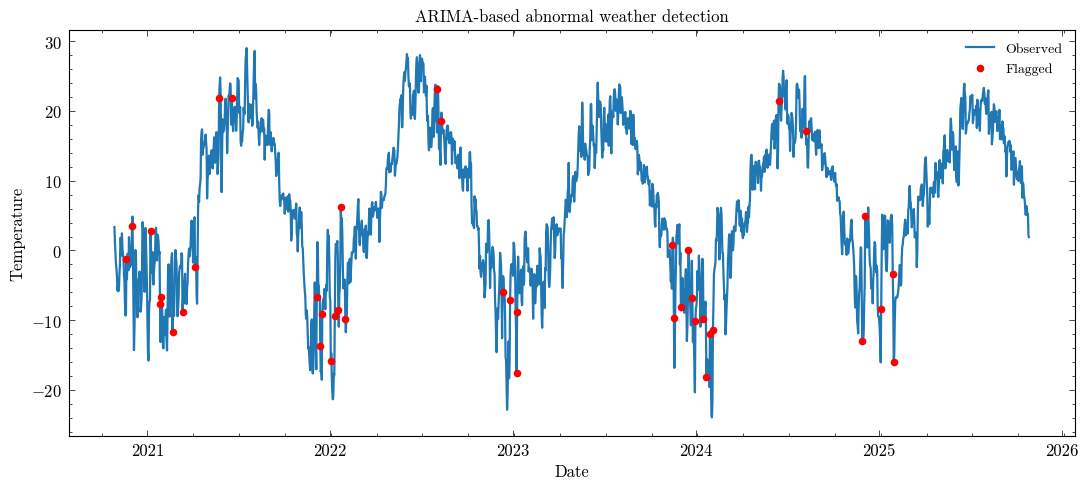

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

y = df["temperature_2m_max"].astype(float)
y.index = pd.to_datetime(df["date"])

# Model: daily seasonality (24); add weekly via Fourier if needed
m = SARIMAX(y, order=(1,0,1), seasonal_order=(1,1,1,7),
            enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

pred = m.get_prediction(dynamic=False)     # one-step-ahead
mean = pred.predicted_mean
ci = pred.conf_int(alpha=0.01)             # 99% interval for fewer flags
lo, hi = ci.iloc[:,0], ci.iloc[:,1]

# robust residual z-score (optional)
resid = y - mean
mad = (resid - resid.median()).abs().median() or resid.std(ddof=1)
z = (resid - resid.median()) / (1.4826 * mad if mad else resid.std(ddof=1))

flag_ci = (y < lo) | (y > hi)
flag_z = z.abs() >= 3.5
flag = flag_ci | flag_z

k = 2
block = (flag.astype(int).diff().fillna(flag.astype(int)) != 0).cumsum()
periods = (
    pd.DataFrame({"flag": flag, "grp": block})
      .loc[flag]
      .groupby("grp")
      .apply(lambda g: pd.Series({"start": g.index.min(), "end": g.index.max(), "len": len(g)}))
      .query("len >= @k")
      .reset_index(drop=True)
)

print("Abnormal periods:")
print(periods)

# 6) Plot
plt.figure(figsize=(11,5))
plt.plot(y.index, y, label="Observed", linewidth=1.6)
# plt.plot(mean.index, mean, "--", label="One-step prediction", linewidth=1.4)
# plt.fill_between(y.index, lo, hi, alpha=0.15, label="95% PI")
plt.scatter(y.index[flag], y[flag], color="red", s=20, zorder=3, label="Flagged")
plt.title("ARIMA-based abnormal weather detection")
plt.xlabel("Date"); plt.ylabel("Temperature"); plt.legend(); plt.tight_layout(); plt.show()


In [25]:
flag

date
2020-10-27 00:00:00+00:00    False
2020-10-28 00:00:00+00:00    False
2020-10-29 00:00:00+00:00    False
2020-10-30 00:00:00+00:00    False
2020-10-31 00:00:00+00:00    False
                             ...  
2025-10-23 00:00:00+00:00    False
2025-10-24 00:00:00+00:00    False
2025-10-25 00:00:00+00:00    False
2025-10-26 00:00:00+00:00    False
2025-10-27 00:00:00+00:00    False
Length: 1827, dtype: bool